# Cost of Displacement Operator: Qubit vs Oscillator-Qubit
The displacement operator acting on a single mode is defined as $D(\alpha) = e^{\alpha a^{\dagger} - \alpha^* a}$. The generating Hamiltonian is then $H = -i(\alpha a^{\dagger} - \alpha^* a)$. We will compare the cost to implement this with $n<50$ logical qubits, versus a noisy cavity (i.e. an oscillator under photon loss).

### Qubit-Only Cost
We will use the Fock Binary encoding, i.e. Fock state $|n\rangle$ is mapped to the qubit state $n$ in base 2.
 

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2

In [26]:
def displacement_operator(n_max):
    """
    Create the matrix representation of the operator b^dagger - b.

    Parameters:
        n_max (int): The Fock cutoff.

    Returns:
        np.ndarray: The matrix representation of b^dagger - b.
    """
    b_dag_minus_b = np.zeros((n_max + 1, n_max + 1), dtype=np.complex128)
    for n in range(n_max + 1):
        if n < n_max:
            b_dag_minus_b[n, n + 1] = -1j * np.sqrt(n + 1)  # b^dagger term
        if n > 0:
            b_dag_minus_b[n, n - 1] = 1j * np.sqrt(n)  # Negative b term
    return b_dag_minus_b

def construct_hamiltonian(n_max):
    """
    Construct the Hamiltonian H = (b^dagger - b).

    Parameters:
        n_max (int): The Fock cutoff.

    Returns:
        SparsePauliOp: The Hamiltonian.
    """
    b_dag_minus_b = SparsePauliOp.from_operator(Operator(displacement_operator(n_max)))
    return b_dag_minus_b

def define_initial_state(n_qubits):
    """
    Define the initial state vector for the system.

    Parameters:
        n_qubits (int): The number of qubits in the system.

    Returns:
        Statevector: The initial quantum state.
    """
    initial_state_vector = np.zeros(2**n_qubits, dtype=complex)
    initial_state_vector[0] = 1.0
    return Statevector(initial_state_vector)


def evolve_system(hamiltonian, initial_state, time):
    """
    Perform time evolution on the system.

    Parameters:
        hamiltonian (SparsePauliOp): The Hamiltonian of the system.
        initial_state (Statevector): The initial quantum state.
        time (float): The total evolution time.

    Returns:
        QuantumCircuit: The evolved quantum circuit.
    """
    problem = TimeEvolutionProblem(hamiltonian, initial_state=initial_state, time=time)
    trotter = TrotterQRTE()
    result = trotter.evolve(problem)
    return result.evolved_state

def analyze_circuit(circuit, backend=GenericBackendV2(3)):
    """
    Analyze the quantum circuit to obtain gate counts and depths.

    Parameters:
        circuit (QuantumCircuit): The quantum circuit to analyze.
        backend (GenericBackendV2): The backend defining supported operations.

    Returns:
        dict: A dictionary containing gate counts, total circuit depth, and Rz gate depth.
    """
    transpiled_circuit = transpile(
        circuit,
        basis_gates=backend.operation_names,
        optimization_level=1
    )
    gate_counts = transpiled_circuit.count_ops()
    total_depth = transpiled_circuit.depth()
    rz_depth = transpiled_circuit.depth(lambda instr: instr.operation.name == 'rz')
    cnot_depth = transpiled_circuit.depth(lambda instr: instr.operation.name == 'cx')

    return {
        "gate_counts": gate_counts,
        "total_depth": total_depth,
        "rz_depth": rz_depth,
        "cnot_depth": cnot_depth
    }


def simulate_system(n_max, final_time=1):
    """
    Simulate the quantum system and analyze the circuit.

    Parameters:
        n_max (int): The maximum quantum number to consider.
        final_time (float): Total evolution time. Defaults to 1.

    Returns:
        dict: Analysis results including gate counts, total depth, and Rz depth.
    """
    # Define system parameters
    n_qubits = int(np.ceil(np.log2(n_max + 1)))
    # Construct the Hamiltonian and initial state
    hamiltonian = construct_hamiltonian(n_max)
    initial_state = define_initial_state(n_qubits)

    # Perform time evolution
    evolved_circuit = evolve_system(hamiltonian, initial_state, final_time)

    # Define a backend and analyze the circuit
    backend = GenericBackendV2(n_qubits)
    analysis_results = analyze_circuit(evolved_circuit, backend)

    return analysis_results

In [27]:
# Define the cutoffs
cutoffs = [2**n - 1 for n in range(2, 11)]

# Initialize lists to store results
rz_gates = []
cnot_gates = []
total_gates = []
total_depths = []
rotation_gate_depths = []
cnot_gate_depths = []

# Simulate the system for each cutoff and collect results
for cutoff in cutoffs:
    results = simulate_system(cutoff)
    rz_gates.append(results["gate_counts"].get('rz', 0))
    cnot_gates.append(results["gate_counts"].get('cx', 0))
    total_gates.append(sum(results["gate_counts"].values()))
    total_depths.append(results["total_depth"])
    rotation_gate_depths.append(results["rz_depth"])
    cnot_gate_depths.append(results["cnot_depth"])

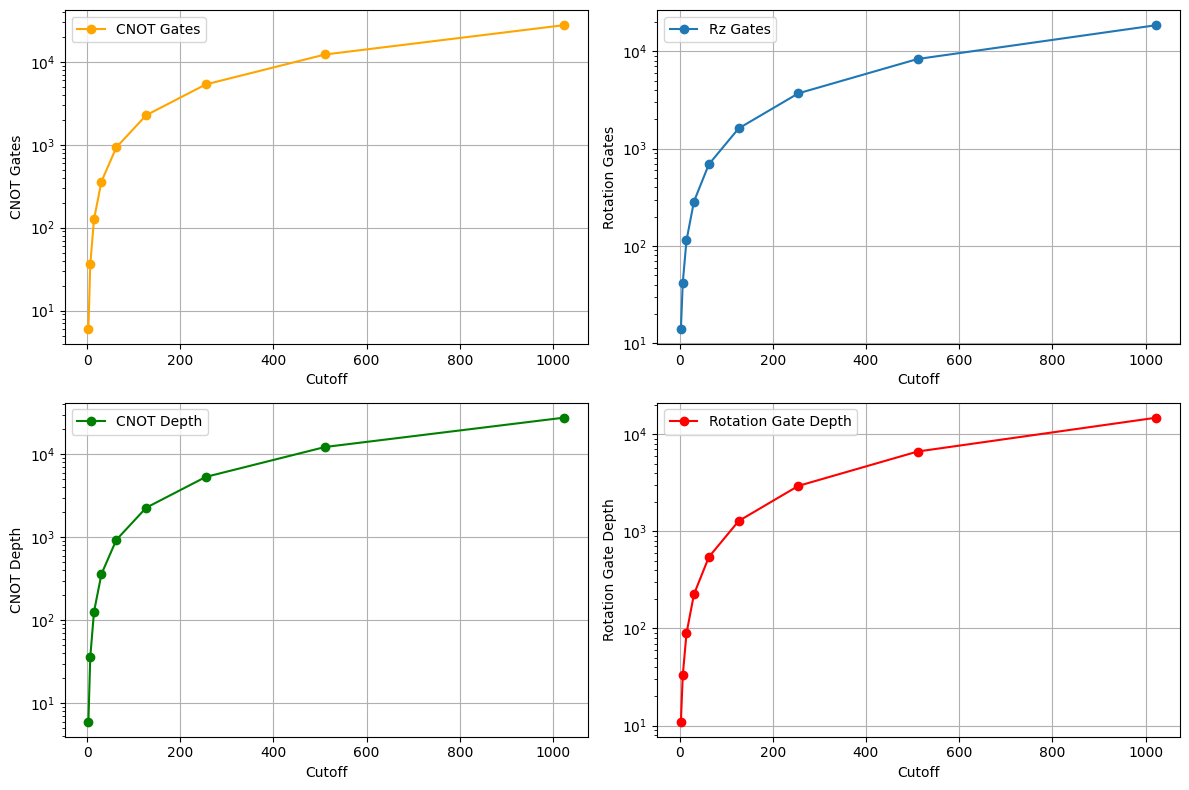

In [ ]:
# Plot labels and data
plots = [
    {"y": cnot_gates, "label": "CNOT Gates", "color": "orange", "ylabel": "CNOT Gates"},
    {"y": rz_gates, "label": "Rotation Gates", "color": None, "ylabel": "Rotation Gates"},
    {"y": cnot_gate_depths, "label": "CNOT Depth", "color": "green", "ylabel": "CNOT Depth"},
    {"y": rotation_gate_depths, "label": "Rotation Gate Depth", "color": "red", "ylabel": "Rotation Gate Depth"},
]

# Create subplots with a log scale
plt.figure(figsize=(12, 8))
for i, plot in enumerate(plots, 1):
    plt.subplot(2, 2, i)
    plt.plot(cutoffs, plot["y"], marker='o', label=plot["label"], color=plot["color"])
    plt.yscale('log')  # Set log scale
    plt.xlabel("Cutoff")
    plt.ylabel(plot["ylabel"])
    plt.grid()
    plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

CNOT Gates Scaling: k=7.56, n=1.18
Rz Gates Scaling: k=5.94, n=1.16
CNOT Depth Scaling: k=7.56, n=1.18
Rotation Gate Depth Scaling: k=4.63, n=1.16


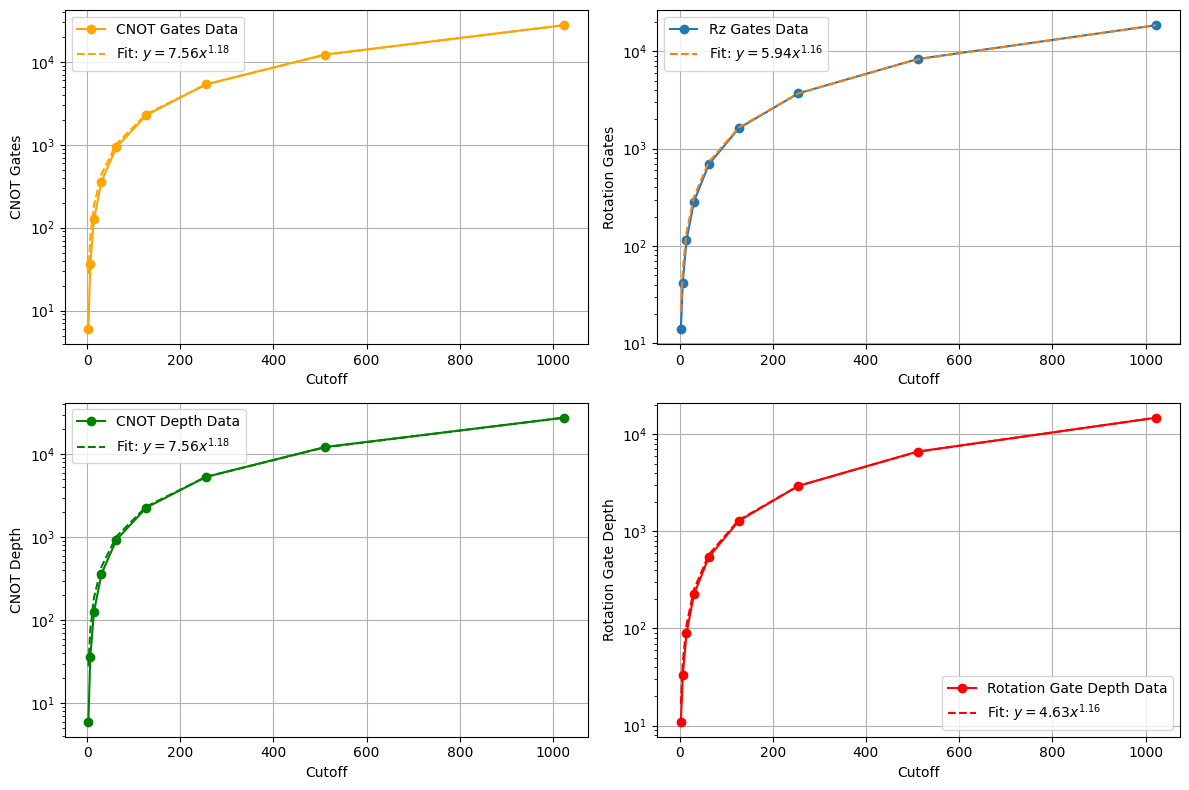

In [29]:
from scipy.optimize import curve_fit

# Define power law function for fitting
def power_law(x, k, n):
    return k * x**n

# Create subplots
plt.figure(figsize=(12, 8))

for i, plot in enumerate(plots, 1):
    y_data = plot["y"]
    
    # Perform curve fitting
    params, _ = curve_fit(power_law, cutoffs, y_data)
    k, n = params
    
    # Print scaling parameters for each dataset
    print(f"{plot['label']} Scaling: k={k:.2f}, n={n:.2f}")
    
    # Plot original data and fit
    plt.subplot(2, 2, i)
    plt.plot(cutoffs, y_data, 'o-', label=f"{plot['label']} Data", color=plot["color"])
    plt.plot(cutoffs, power_law(cutoffs, *params), '--', 
         label=f"Fit: $y = {k:.2f}x^{{{n:.2f}}}$", color=plot["color"]) 
    plt.yscale('log')  # Set log scale

    plt.xlabel("Cutoff")
    plt.ylabel(plot["ylabel"])
    plt.grid()
    plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()